# CS 498 AML HW 7
Roshan Rajan (rjrajan2)<br>
Kirsten Wong (kewong2)<br>
Kenneth Zhang (kfzhang2)<br>

### Mean Inference for Binary Images

#### Initialization
Read in the MNIST dataset.

In [40]:
% matplotlib inline
from matplotlib import pyplot as plt

In [41]:
# %load mnist.py
# File for opening mnist dataset
# Source: https://gist.github.com/akesling/5358964
import os
import struct
import numpy as np

"""
Loosely inspired by http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
which is GPL licensed.
"""

def read(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError, "dataset must be 'testing' or 'training'"

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in xrange(len(lbl)):
        yield get_img(i)

def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()


In [42]:
training_data = list(read(dataset = "training", path = '.'))

In [43]:
# Get first 500 images
training_data = training_data[0:500]

Make two forms of data: list of 28x28 images, and list of length 784 pixels. The images are binarized to (-1,1)-space.

In [105]:
im_data = []
for i in range(0,500):
    temp = (np.mat(training_data[i][1]) > 0.5).astype(int) - (np.mat(training_data[i][1]) <= 0.5).astype(int)
    im_data.append(temp)

In [110]:
im_data_b = im_data
for i in range(0,len(im_data_b)):
    im_data_b[i] = im_data_b[i].astype('uint8')

In [96]:
im_data_2 = np.ndarray((0,784))
for i in range(0,500):
    temp = np.reshape((training_data[i][1]).astype(int),(1,784))
    temp = (np.mat(temp > 0.5).astype(int) - (np.mat(temp) <= 0.5).astype(int))
    im_data_2 = np.append(im_data_2,temp,0)

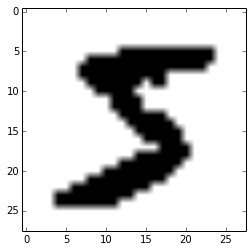

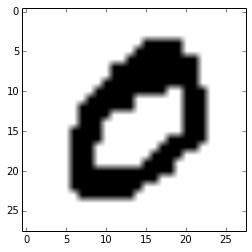

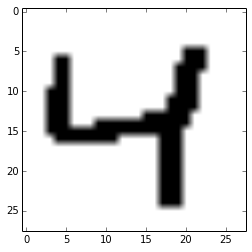

In [116]:
plt.figure()
plt.imshow(im_data[0],cmap='gray')
plt.figure()
plt.imshow(im_data[1],cmap='gray')
plt.figure()
plt.imshow(im_data[2],cmap='gray')

We will use the first 500 of the training set images.
Obtain the MNIST training set, and binarize the first 500 images by mapping any value below .5 to -1 and any value above to 1. For each image, create a noisy version by randomly flipping 2% of the bits.
Now denoise each image using a Boltzmann machine model and mean field inference. Use theta_{ij}=0.2 for the H_i, H_j terms and theta_{ij}=2 for the H_i, X_j terms. To hand in: Report the fraction of all pixels that are correct in the 500 images.